In [1]:
import re
import pandas as pd
import itertools
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import spacy
# import neuralcoref #
from spacy import displacy
try:
    nlp = spacy.load('en_core_web_lg')
except:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher 
from spacy.tokens import Span 

## Load Data

In [2]:
df = pd.read_excel('tesco.xlsx',skiprows=2)
df[:2]

,id,text
0,0,"Tesco has been hit by hackers, leaving thousan..."
1,1,The outage leaves its grocery website and app ...


## Model
 - [coreference resolution](https://spacy.io/universe/project/neuralcoref)
 - [named entity recognition]()
 
##  Coreference

## Named Entity Recognition
To extract the named entities

In [3]:
# pre-processing
df['text-clean'] = df['text'].apply(lambda x: re.sub(r"(\w+)'s", r'\1s', x))

df[:2]

,id,text,text-clean
0,0,"Tesco has been hit by hackers, leaving thousan...","Tesco has been hit by hackers, leaving thousan..."
1,1,The outage leaves its grocery website and app ...,The outage leaves its grocery website and app ...


In [4]:
# customer NER
try:
    nlp.remove_pipe('entity_ruler')
except:
    config = {
       "phrase_matcher_attr": None,
       "validate": True,
       "overwrite_ents": True,
       "ent_id_sep": "||",
    }
    ruler = nlp.add_pipe("entity_ruler", config=config)
    patterns = [
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(?i)(customer)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(?i)(shopper)s?' }} ]},
                {'label': 'GROUP', 'pattern': [{'TEXT': {'REGEX': r'(?i)(?i)(hacker)s?' }} ]},
                ]
    ruler.add_patterns(patterns)

In [5]:
# apply nlp
df['doc'] = df['text-clean'].apply(lambda x: nlp(x))
spacy.displacy.render(df['doc'][1], style='ent')
spacy.displacy.render(df['doc'][1], style='dep')

## Get the entities and nouns

In [12]:
# example doc
doc = df['doc'][0]
# doc = nlp("Ben was born in Hawaii. He owns two cats")
for tok in doc:
    if tok.pos_ in ['PROPN','NOUN','PRON']:
        print((tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
    else:
        print('\t',(tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))

('Tesco', 'PROPN', 'nsubjpass', 'ORG', 0, 0)
	 ('Has', 'AUX', 'aux', '', 1, 6)
	 ('Been', 'AUX', 'auxpass', '', 2, 10)
	 ('Hit', 'VERB', 'ROOT', '', 3, 15)
	 ('By', 'ADP', 'agent', '', 4, 19)
('Hackers', 'NOUN', 'pobj', 'GROUP', 5, 22)
	 (',', 'PUNCT', 'punct', '', 6, 29)
	 ('Leaving', 'VERB', 'advcl', '', 7, 31)
('Thousands', 'NOUN', 'dobj', 'CARDINAL', 8, 39)
	 ('Of', 'ADP', 'prep', '', 9, 49)
	 ('Frustrated', 'ADJ', 'amod', '', 10, 52)
('Shoppers', 'NOUN', 'pobj', 'GROUP', 11, 63)
	 ('Unable', 'ADJ', 'amod', '', 12, 72)
	 ('To', 'PART', 'aux', '', 13, 79)
	 ('Buy', 'VERB', 'xcomp', '', 14, 82)
('Groceries', 'NOUN', 'dobj', '', 15, 86)
	 ('Online', 'ADV', 'advmod', '', 16, 96)
	 ('At', 'ADP', 'prep', '', 17, 103)
('Britain', 'PROPN', 'poss', 'GPE', 18, 106)
	 ('’S', 'PART', 'case', '', 19, 113)
	 ('Biggest', 'ADJ', 'amod', '', 20, 116)
('Supermarket', 'NOUN', 'pobj', '', 21, 124)
	 ('.', 'PUNCT', 'punct', '', 22, 135)


In [13]:
# get entities
def get_entities(doc):
    entities = dict()
    for tok in doc:
        if tok.pos_ in ['PROPN','NOUN','PRON']:
            entities[tok.i] = tok # token.i is int location in doc
            # print((tok.text.title(),tok.pos_,tok.dep_,tok.ent_type_,tok.i,tok.idx))
    return entities

entities = get_entities(doc)
entities

{0: Tesco,
 5: hackers,
 8: thousands,
 11: shoppers,
 15: groceries,
 18: Britain,
 21: supermarket}

In [14]:
# get ordered entity pairs
def get_entity_pairs(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return {e:{'from':x[0],'to':x[1]} for e,x in enumerate(zip(a, b))}
entity_pairs = get_entity_pairs(entities.keys())
entity_pairs

{0: {'from': 0, 'to': 5},
 1: {'from': 5, 'to': 8},
 2: {'from': 8, 'to': 11},
 3: {'from': 11, 'to': 15},
 4: {'from': 15, 'to': 18},
 5: {'from': 18, 'to': 21}}

In [15]:
# get edge text
def get_entity_edges(entity_pairs):
    for k in list(entity_pairs.keys()):
        v = entity_pairs[k]
        edge_text = [t.text for t in doc[v['from']:v['to']+1] if t.pos_ in ['VERB','ADP','ADJ']]
        edge_text = ' '.join(edge_text)
        if len(edge_text) == 0:
            del entity_pairs[k]
        else:
            v['edge'] = edge_text
    
get_entity_edges(entity_pairs)
entity_pairs

{0: {'from': 0, 'to': 5, 'edge': 'hit by'},
 1: {'from': 5, 'to': 8, 'edge': 'leaving'},
 2: {'from': 8, 'to': 11, 'edge': 'of frustrated'},
 3: {'from': 11, 'to': 15, 'edge': 'unable buy'},
 4: {'from': 15, 'to': 18, 'edge': 'at'},
 5: {'from': 18, 'to': 21, 'edge': 'biggest'}}

## view relations between entities and nouns

In [16]:
# create graph
G=nx.Graph(name='simple KG')

for k,node in entities.items():
    G.add_node(k,name=node.text.title(), ent_typ=node.ent_type_, pos=node.pos_) 
node_labels = {node[0]:node[1]['name'] for node in G.nodes(data=True)}

edges = [(v['from'],v['to'],{'weight':1}) for v in entity_pairs.values()]
edge_labels = {(v['from'],v['to']):v['edge'] for v in entity_pairs.values()}
G.add_edges_from(edges)

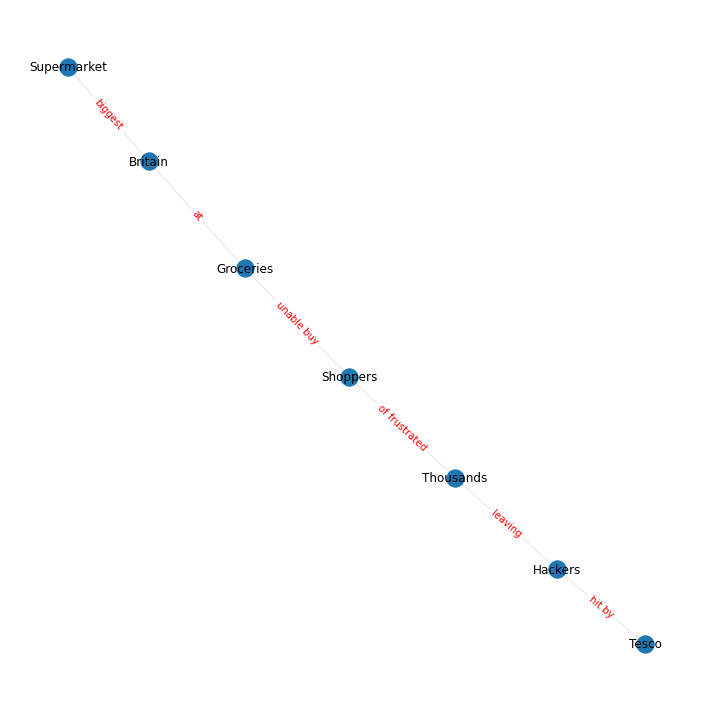

In [17]:
# plot graph
fig,ax = plt.subplots(1,1, figsize=(10,10))
pos = nx.spring_layout(G,seed=10)
nx.draw(G, 
        ax=ax,
        pos=pos,
        labels=node_labels,
        width=0.1)

nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels=edge_labels,
                             font_color='red')
plt.tight_layout()